In [367]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
import math

In [280]:
dist_df = pd.read_table('distmat_results/dist.tsv', header=None, index_col=[0,1,2])
dist_df.index.rename(['chrom', 'start', 'end'], inplace=True)
dist_df.rename(columns=dict(zip(dist_df.columns.values, 
                                [x-2 for x in dist_df.columns.values])), 
               inplace=True)

covr_df = pd.read_table('distmat_results/coverage.tsv', header=None, index_col=[0,1,2])
covr_df.index.rename(['chrom', 'start', 'end'], inplace=True)
covr_df.rename(columns=dict(zip(covr_df.columns.values, 
                                [x-2 for x in covr_df.columns.values])), 
               inplace=True)

In [282]:
compl_df = dist_df.where(covr_df > 0.5).dropna()

In [470]:
import random

class Node(object):
    
    def __init__(self, **kwarg):
        self.left, self.right = None, None
        self.dist_left, self.dist_right = None, None
        for k, v in kwarg.items():
            setattr(self, k, v)

    def __str__(self):
        sList = []
        if self.left and self.right:
            return "(%s:%f,%s:%f)" % (str(self.left), self.dist_left, 
                                      str(self.right), self.dist_right)
        else:
            return str(self.name)

names = ['A', 'B', 'C', 'D']
dist = [[0.0,8.0,40.0,40.0], 
        [8.0,0.0,40.0,40.0], 
        [40.0,40.0,0.0,2.0], 
        [40.0,40.0,2.0,0.0]]

def nj(dist, names=None):
    if not names:
        names = map(str, range(len(dist)))
    else:
        len(names) == len(dist)

    nodes = dict()
    for i, name in enumerate(names):
        nodes[i] = Node(name=name)

    live_nodes = len(names)
        
    d = dict()
    for i, row in enumerate(dist):
        if i not in d:
            d[i] = dict()
        for j, val in enumerate(row):
            d[i][j] = val

    def get_r(x):
        return sum(d[x].values())/float(live_nodes - 2)
            
    def get_pair():
        q = list()
        
        r = dict()
        for i in d:
            r[i] = sum(d[i].values())/float(live_nodes - 2)

        mind = float('inf')
        pair = None
        for i in d:
            for j in d:
                if i == j: continue
                qij = d[i][j] - r[i] - r[j]
                if qij < mind:
                    mind = qij
                    pair = (i, j)
        return pair

    def update_distances(i, j):
        
        dik = (d[i][j] + get_r(i) - get_r(j)) / 2.0
        djk = d[i][j] - dik

        k = len(nodes)
        d[k] = dict()
        for x in d:
            if k != x:
                d[k][x] = (d[i][x] + d[j][x] - d[i][j]) / 2.0
            else:
                d[k][x] = 0.0
            d[x][k] = d[k][x]
                    
        del d[i]
        del d[j]

        return dik, djk
        
    while live_nodes > 2:
        i, j = get_pair()
        dik, djk = update_distances(i, j)        
        nodes[len(nodes)] = Node(left=nodes[i], right=nodes[j], dist_left=dik, dist_right=djk)
        live_nodes -= 1

    i, j = d.keys()
    dij = d[i][j] / 2.0

    nodes[len(nodes)] = Node(left=nodes[i], right=nodes[j], dist_left=dij, dist_right=dij)
    return nodes

def branch_sum(tree):
    return sum(x.dist_right + x.dist_left for x in tree.values() if x.left and x.right)

def mean_external_branch_length(tree):
    
    def external_branch_lengths(node):
        lst = list()
        if node.left.left:
            lst += external_branch_lengths(node.left)
        else:
            lst += [node.dist_left]
        if node.right.right:
            lst += external_branch_lengths(node.right)
        else:
            lst += [node.dist_right]
        return lst
    externals = external_branch_lengths(tree[len(tree)-1])
    return sum(externals)/float(len(externals))
    
def print_tree(t):
    print str(t[len(t)-1])

tree = nj(dist, names)
print_tree(tree)
print branch_sum(tree)
print mean_external_branch_length(tree)

((A:4.000000,B:4.000000):17.500000,(C:1.000000,D:1.000000):17.500000)
45.0
2.5


In [471]:
def matrix(l):
    n = int(math.sqrt(len(l)))
    assert not len(l) % n
    m = list()
    for i in range(0, len(l), n):
        m.append(map(float, l[i:i+n]))
    return m

def total_branch_length(row):
    l = list(row)
    dist = matrix(l)
    tree = nj(dist)
    return branch_sum(tree)

def pi(row):
    return sum(row)/float(len(row))

In [451]:
mean_dist = compl_df.apply(pi, axis=1)

#branch_sums = compl_df.apply(total_branch_length, axis=1)

In [445]:
trees = [nj(matrix(list(row[1]))) for row in compl_df.iterrows()]

In [475]:
df = (mean_dist
    .to_frame(name='mean_dist')
    .assign(brsum=[branch_sum(t) for t in trees])
    .assign(mean_ext=[mean_external_branch_length(t) for t in trees])
)

In [478]:
# df = pd.concat([branch_sums, pi], axis=1)
# df.columns = ['branch_lengths', 'Pi']
df = df.reset_index()
#br_df.rename(columns={0: 'brlen'}, inplace=True)


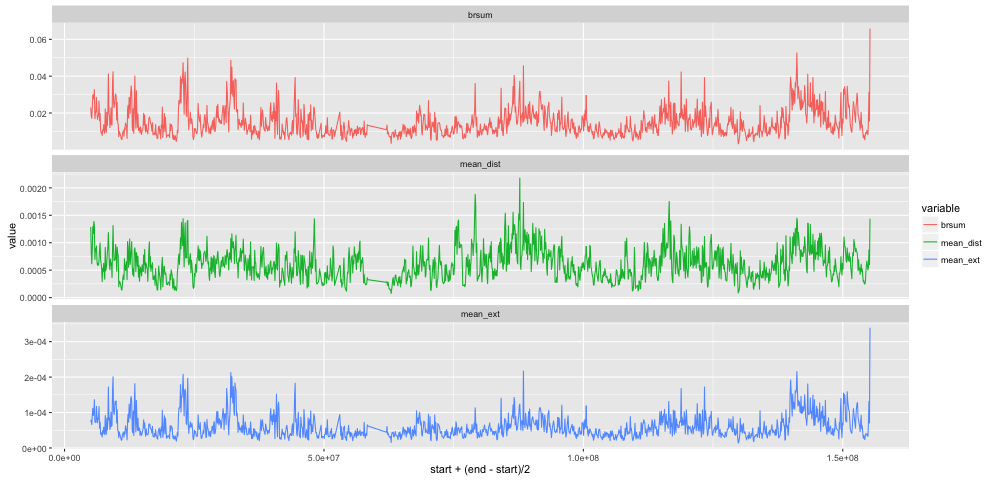

In [479]:
%%R -i df -w 1000

library(ggplot2)
library(magrittr)
library(dplyr)
library(tidyr)

df %>% 
    filter(end > 5e6) %>%
    gather(variable, value, -(chrom:end)) %>%
ggplot(aes(x=start+(end-start)/2, y=value, colour=variable)) + geom_line() +
facet_wrap( ~ variable, scales='free_y', ncol=1)

In [400]:


#df.merge(df.textcol.apply(lambda s: pd.Series({'feature1':s+1, 'feature2':s-1})), 
#    left_index=True, right_index=True)

                           branch_lengths        Pi
chrom start     end                                
X     300000    400000           0.173339  0.003061
      400000    500000           0.195510  0.003106
      500000    600000           0.168283  0.002737
      600000    700000           0.178423  0.002818
      700000    800000           0.140329  0.002403
      800000    900000           0.139688  0.002398
      900000    1000000          0.162960  0.002639
      1200000   1300000          0.179550  0.003036
      1300000   1400000          0.141999  0.002471
      1400000   1500000          0.190456  0.003033
      1500000   1600000          0.105653  0.002118
      1600000   1700000          0.125287  0.002224
      1700000   1800000          0.168103  0.002659
      1800000   1900000          0.121616  0.002006
      1900000   2000000          0.097631  0.001854
      2000000   2100000          0.119025  0.001962
      2100000   2200000          0.054129  0.001788
      220000

1470


In [19]:
print df

          0          1          2   pair  dist
0         X          0     100000      3     0
1         X     100000     200000      3     0
2         X     200000     300000      3     0
3         X     300000     400000      3     0
4         X     400000     500000      3     0
5         X     500000     600000      3     0
6         X     600000     700000      3     0
7         X     700000     800000      3     0
8         X     800000     900000      3     0
9         X     900000    1000000      3     0
10        X    1000000    1100000      3     0
11        X    1100000    1200000      3     0
12        X    1200000    1300000      3     0
13        X    1300000    1400000      3     0
14        X    1400000    1500000      3     0
15        X    1500000    1600000      3     0
16        X    1600000    1700000      3     0
17        X    1700000    1800000      3     0
18        X    1800000    1900000      3     0
19        X    1900000    2000000      3     0
20        X  

In [ ]:
result = pd.concat([dist_df, cov_df], axis=1, join_axes=[dist_df.index])